# Demonstration of VAE-based Models

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

from energy_data_enricher.models import *
from energy_data_enricher.utils import *
from energy_data_enricher.comparison import *


Load Data

In [2]:
# Load data as dataframe
df = pd.read_csv('data/europe.csv')
countries = df.columns.tolist()
data = torch.tensor(df.values, dtype=torch.float32)
# randomly split data into train and test
train_idx = np.random.choice(data.shape[0], int(0.8 * data.shape[0]), replace=False)
test_idx = np.setdiff1d(np.arange(data.shape[0]), train_idx)
train_data = data[train_idx]
test_data = data[test_idx]

Initialize Model

In [6]:
model = VAE(input_dim=data.shape[1], latent_dim=5, num_hidden_layers=2, num_neurons=10)

Train Model

In [7]:
model.train(x=train_data, beta=0.5, mc_samples=2, learning_rate=2e-3, epochs=50, batch_size=32)

Iteration: 100/2600 -- ELBO=-2.22e+01 / RLL=-2.21e+01 / KL=6.03e-02
Iteration: 200/2600 -- ELBO=-1.88e+01 / RLL=-1.76e+01 / KL=1.17e+00
Iteration: 300/2600 -- ELBO=-1.60e+01 / RLL=-1.39e+01 / KL=2.08e+00
Iteration: 400/2600 -- ELBO=-1.25e+01 / RLL=-1.02e+01 / KL=2.31e+00
Iteration: 500/2600 -- ELBO=-1.46e+01 / RLL=-1.20e+01 / KL=2.58e+00
Iteration: 600/2600 -- ELBO=-1.14e+01 / RLL=-8.67e+00 / KL=2.78e+00
Iteration: 700/2600 -- ELBO=-1.07e+01 / RLL=-8.15e+00 / KL=2.58e+00
Iteration: 800/2600 -- ELBO=-1.17e+01 / RLL=-8.93e+00 / KL=2.73e+00
Iteration: 900/2600 -- ELBO=-1.19e+01 / RLL=-9.17e+00 / KL=2.70e+00
Iteration: 1000/2600 -- ELBO=-1.12e+01 / RLL=-8.45e+00 / KL=2.72e+00
Iteration: 1100/2600 -- ELBO=-1.21e+01 / RLL=-8.91e+00 / KL=3.14e+00
Iteration: 1200/2600 -- ELBO=-1.03e+01 / RLL=-7.50e+00 / KL=2.81e+00
Iteration: 1300/2600 -- ELBO=-1.09e+01 / RLL=-7.92e+00 / KL=2.97e+00
Iteration: 1400/2600 -- ELBO=-1.10e+01 / RLL=-8.19e+00 / KL=2.84e+00
Iteration: 1500/2600 -- ELBO=-1.24e+01 / RL

Take Samples for Visualization

In [8]:
num_samples = train_data.shape[0]

sample_param_dict = model.sample(num_samples_prior=num_samples, num_samples_likelihood=3)

samples = sample_param_dict["samples"].flatten(end_dim=1).detach().numpy()

train_data_list = [['Training data']+x for x in train_data.tolist()]
sample_list = [['Generated data']+x for x in samples.tolist()]
pair_df = pd.DataFrame(train_data_list+sample_list,columns=['type']+countries)

pair_df_filtered = pair_df.loc[:, ['type', 'NO', 'FR', 'IT']]

country_mask = [country in ['NO', 'FR', 'IT'] for country in countries]


Compare Samples Visually

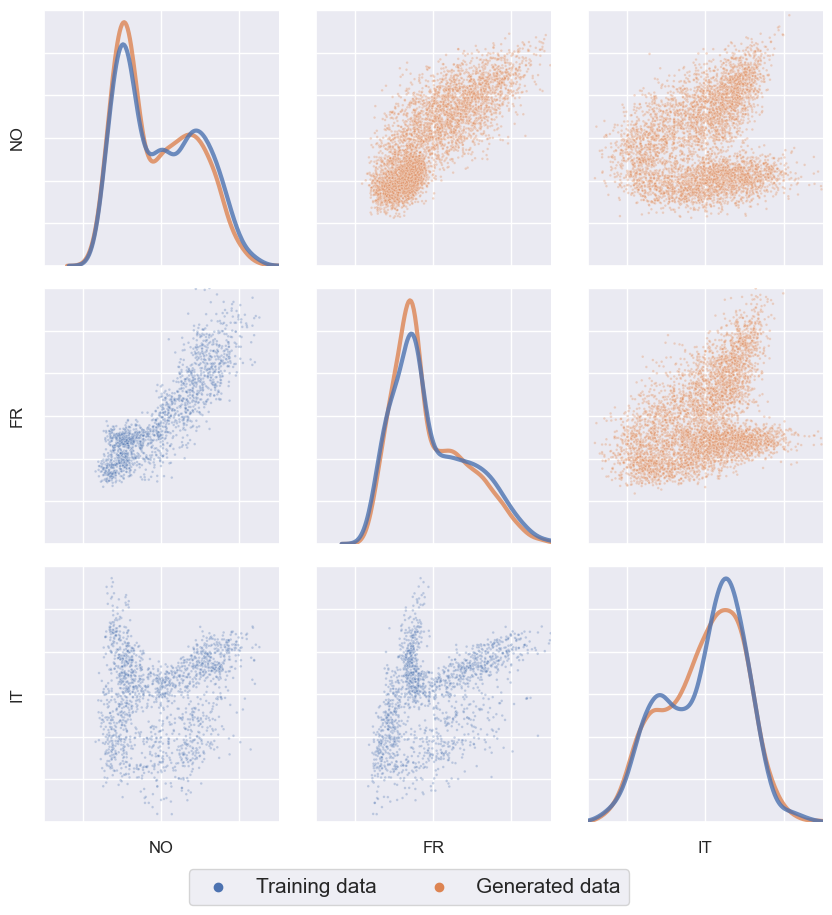

In [9]:
g = sns.PairGrid(pair_df_filtered, diag_sharey=False, hue="type", height=3, aspect=1.0)
g.map_diag(sns.kdeplot, common_norm=False, lw=3, alpha=0.8)

g.data = pair_df_filtered[pair_df_filtered['type'] != 'Generated data']
g.map_lower(sns.scatterplot, s=15, alpha=0.3, edgecolors='face', linewidths=0.0, marker='.')

g.data = pair_df_filtered[pair_df_filtered['type'] == 'Generated data']
g.map_upper(sns.scatterplot, s=15, alpha=0.3, edgecolors='face', linewidths=0.0, marker='.')

lims = 3.0
g.set(xlim=[-lims,lims], ylim=[-lims,lims])
g.set(xticklabels=[], yticklabels=[])

g.add_legend(title='', ncol=2, bbox_to_anchor=(0.525, -0.0), frameon=True, fontsize=15)
plt.show()

Sample and Model Comparison Scores

In [17]:
sample_param_dict = model.sample(num_samples_prior=num_samples, num_samples_likelihood=1)

samples = sample_param_dict["samples"].flatten(end_dim=1).detach()

sample_test = "energy"
model_scores, base_scores = sample_comparison(model_samples=samples, train_samples=train_data, test_samples=test_data, test=sample_test, subsample_ratio=0.4, mc_runs=1000)

In [18]:
model_test = "ks"
model_score = model_comparison(model_scores=model_scores, base_scores=base_scores, test=model_test)

[]

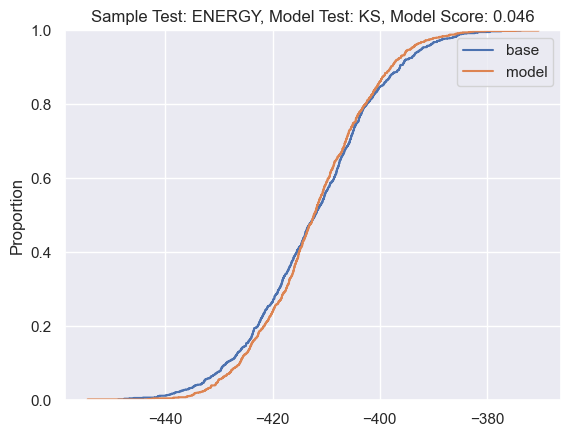

In [19]:
sns.ecdfplot(base_scores, label='base')
sns.ecdfplot(model_scores, label='model')
plt.legend()
plt.title(f"Sample Test: {sample_test.upper()}, Model Test: {model_test.upper()}, Model Score: {model_score:.3f}")
plt.plot()